In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.misc import derivative # I found it!
import time
import torch 

/Users/markviti/opt/anaconda3/envs/data/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Question 1

Batch size: 1, Time: 50.94s, Count: 100
Batch size: 10, Time: 4.08s, Count: 78
Batch size: 100, Time: 0.37s, Count: 58
Batch size: 1000, Time: 0.01s, Count: 5


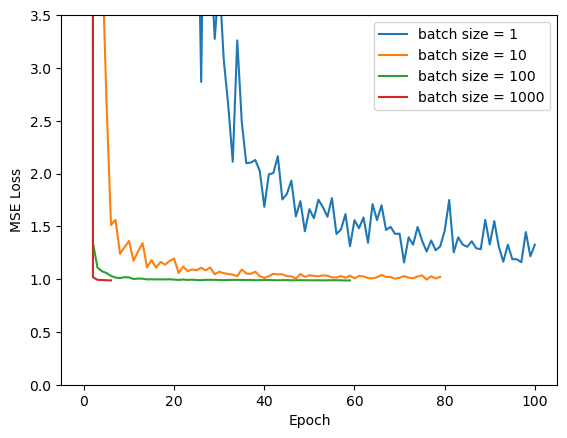

In [40]:
data = pd.read_csv('reg.csv')

y = np.array(data['y'])
x = np.array(data.iloc[:, 2:])
X = x.copy()
rows, cols = X.shape


def sgd(X, y, lr=0.9, epochs=100, batch_size=1, early_stop=True):
    """
    Stochastic Gradient Descent (SGD) with objective function history.
    
    Parameters:
    - X: numpy array of input features, shape (n_samples, n_features)
    - y: numpy array of target values, shape (n_samples,)
    - lr: learning rate
    - epochs: number of iterations over the dataset
    - batch_size: size of the batch used in each iteration
    
    Returns:
    - w: learned weights, shape (n_features,)
    - b: learned bias
    - loss_history: list of MSE loss values at each epoch, including the initial loss
    """
    
    n_samples, n_features = X.shape
    w = np.zeros(n_features)
    b = 0
    loss_history = []
    counter = 0 # Counter to keep track of the number of iterations
    
    initial_loss = np.mean((np.dot(X, w) + b - y) ** 2)
    loss_history.append(initial_loss)
    
    for epoch in range(epochs):
        indexes = np.random.permutation(n_samples)
        X_shuffled = X[indexes]
        y_shuffled = y[indexes]
        lr = 1 / (1 + counter)
        
        for i in range(0, n_samples, batch_size):
            X_i = X_shuffled[i:i+batch_size]
            y_i = y_shuffled[i:i+batch_size]
            
            y_pred = np.dot(X_i, w) + b 
            w_grad = -2 * np.dot(X_i.T, (y_i - y_pred)) / batch_size 
            b_grad = -2 * np.sum(y_i - y_pred) / batch_size

            w_grad = np.clip(w_grad, -10, 10)
            b_grad = np.clip(b_grad, -10, 10)
            
            w -= lr * w_grad 
            b -= lr * b_grad 

        loss = np.mean((np.dot(X, w) + b - y) ** 2)
        loss_history.append(loss)
        # converge if gradient is small enough
        if early_stop:
            if np.abs(b_grad) < 1e-2:
                return w, b, loss_history, counter
        counter += 1

    
    return w, b, loss_history, counter

for batch in [1, 10, 100, 1000]:
    time_start = time.time()
    w, b, loss_history, counter = sgd(X, y, lr=0.9, epochs=100, batch_size=batch)
    time_end = time.time()
    print(f'Batch size: {batch}, Time: {time_end - time_start:.2f}s, Count: {counter}')
    plt.plot(loss_history, label=f'batch size = {batch}')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.ylim(0, 3.5)
plt.legend()
plt.show()

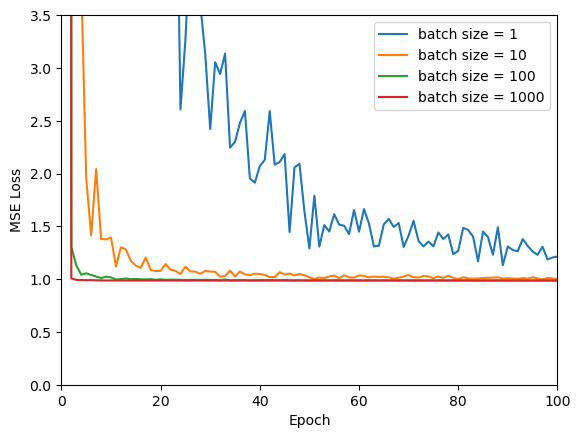

In [42]:
# zoomed in graph 
for batch in [1, 10, 100, 1000]:
    w, b, loss_history,_ = sgd(X, y, lr=0.9, epochs=100, batch_size=batch, early_stop=False)
    plt.plot(loss_history, label=f'batch size = {batch}')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.ylim(0, 3.5)
plt.xlim(0, 100)
plt.show()


In [27]:
# does the loss_history for 1000 never increase?
w, b, loss_history = sgd(X, y, lr=0.9, epochs=100, batch_size=1000)
if np.all(np.diff(loss_history) > 0):
    print('The loss_history for batch size 1000 never increases.')
else:
    print(f'The loss_history for batch size 1000 increases at point {np.argmax(np.diff(loss_history))}.')
    print(f'Loss at the point: {loss_history[np.argmax(np.diff(loss_history))]} and then {loss_history[np.argmax(np.diff(loss_history)) + 1]}')

The loss_history for batch size 1000 increases at point 12.
Loss at the point: 0.9869868448537247 and then 0.9870595137393466


Yes for both 1000 and 1, we see that there is a point at which the loss increases. That is because we are using stochastic gradient descent, which means that the loss function is not guaranteed to decrease at every step. It is only guaranteed to decrease on average. This is because the gradient is calculated using only one data point at a time, and so the direction of the gradient is not guaranteed to be the same as the direction of the average gradient. This means that the loss function can increase at any given step, but on average it will decrease. Notice that the differences in increases between loses is very different depending on the batch size. This is because the law of large numbers kicks in and this gradient average is more accurate. 

We can see that for 10, 100, and 1000 sized batches, the code runs very fast, less than 1 second. Note that the time decreases as the batch size increases. However, for a batch size of 1, the time is much longer, about 50-60 seconds. This is because we are not reaching the optimal solution as quickly as we would with a larger batch size and thus computing difficult gradients for many points. 

In terms of the number of iterations, we can see that the number of iterations until convergence decreases as the batch size increases. Note that batch = 1 did not converge at 100 steps: I just did not believe my computer could handle much more than 100 steps (she's old). Thus to conclude: both the number of iterations and the time to convergence decrease as the batch size increases as we realize the benefits of the law of large numbers.

# Problem 2
1. We will show show the $L_0$ norm is not convex. Recall that $||B_0||_0 = \left\{ i : b_i \neq 0 \right\}$. So, let $x = \left\{ 1, 0 \right\}$ and $y = \left\{ 0, 1 \right\}$. Then, $||x||_0 = 1$ and $||y||_0 = 1$. However, $||\frac{x + y}{2}||_0 = 2$. Now, we have that $||\frac{1}{2}\cdot x + \frac{1}{2}\cdot y||_0 \leq \frac{1}{2}\cdot||x||_0 + \frac{1}{2}\cdot||y||_0$ is the definition of convexity. And so we have that 
$\begin{align}
||\frac{1}{2}\cdot x + \frac{1}{2}\cdot y||_0 &\leq \frac{1}{2}\cdot||x||_0 + \frac{1}{2}\cdot||y||_0 \\
2 & \leq \frac{1}{2} + \frac{1}{2} \\
\end{align}$
Which of course is not true. Thus, the $L_0$ norm is not convex.

2. We will use the result from the previous PSET to show that the $L_0$ norm is not a norm. Recall that we showed before that all norms are convex. Since the $L_0$ norm is not convex, it is not a norm.

3. We will now show that the $L_1$ norm is convex. To do this, we will show that the $L_1$ norm is a norm, which by the last PSET will imply convexity. 

    i. We will show that the $L_1$ norm is non-negative. This is clear since the absolute value of any number is non-negative.

    ii. We will show that the $L_1$ norm is zero if and only if the vector is the zero vector. This is clear since the absolute value of any number is zero if and only if the number is zero.

    iii. We will show that the $L_1$ norm satisfies the triangle inequality. This is clear since the absolute value of the sum of two numbers is less than or equal to the sum of the absolute values of the two numbers. That is $|a + b| \leq |a| + |b|$. If this is not immediately obvious, note that $|a + b| = |a| + |b|$ if $a$ and $b$ have the same sign, and $|a + b| = |a| - |b|$ if $a$ and $b$ have different signs. In either case, the triangle inequality holds.  
    
    iv. We will show that the $L_1$ norm is homogenous. This is clear since the absolute value of the product of a number and a vector is equal to the absolute value of the number times the absolute value of the vector.

Therefore, the $L_1$ norm is a norm, and thus convex.

4. We will now show that the $L_2$ norm is convex. To do this, we will show that the $L_2$ norm is a norm, which by the last PSET will imply convexity. 

    i. We will show that the $L_2$ norm is non-negative. This is clear since the square of any number is non-negative.

    ii. We will show that the $L_2$ norm is zero if and only if the vector is the zero vector. This is clear since the square of any number is zero if and only if the number is zero.

    iii. We will show that the $L_2$ norm satisfies the triangle inequality. 
    $\begin{align}
    ||x + y||_2^2 &= \sum_{i=1}^{n} (x_i + y_i)^2 \\
    &= \sum_{i=1}^{n} x_i^2 + 2x_iy_i + y_i^2 \\
    &= \sum_{i=1}^{n} x_i^2 + \sum_{i=1}^{n} 2x_iy_i + \sum_{i=1}^{n} y_i^2 \\
    & \leq  \vert\vert x \vert\vert_2^2 + 2\vert\vert x \vert\vert_2\vert\vert y \vert\vert_2 + \vert\vert y \vert\vert_2^2  && \text{Cauchy-Schwartz}\\ 
    \implies \vert\vert x + y \vert\vert_2^2 & \leq \left( \vert\vert x \vert\vert_2 + \vert\vert y \vert\vert_2 \right)^2 \\
    \end{align}$

    iv. We will show that the $L_2$ norm is homogenous. This is clear since the square of the product of a number and a vector is equal to the square of the number times the square of the vector. That is $||\alpha x||_2 = \alpha^2||x||_2$.

Therefore, the $L_2$ norm is a norm, and thus convex.

5. We will now show that $\alpha ||\beta||_1 + (1 - \alpha)||\beta||_2$ is convex. Note this is very easy. Since the $L_1$ and $L_2$ norms are convex, and since the sum of convex functions is convex (as we proved on the last PSET), we have that $\alpha ||\beta||_1 + (1 - \alpha)||\beta||_2$ is convex.

6. To find out which of these norms results in a convex regression problem for the objective $\min_{\beta} \frac{1}{n}\sum_{i = 1}^n \left(y_i - x_i\beta\right)^2 + \lambda h(\beta)$ is convex. First, now that we have already shown that the first part of the summand is convex. Since the sum of two convex functions is convex (as shown on the last PSET), it must be the case that the entire function is convex for the convex norms. Thus, the $L_1$ and $L_2$ norms result in a convex regression problem. Moreover, the elastic-net problem is also convex. However, the $L_0$ norm does not result in a convex regression problem since this function is not always convex. 

# Problem 3
## Part 1
*We do not have any graduate students in the class, so we will not be able to complete this part of the problem.*

## Part 2

In [43]:
# load smoking data - MV

smoking = pd.read_csv('soo.csv')
smoking = smoking.drop('Unnamed: 0', axis=1)
smoking.head()

,exyr,smoking,age
0,47.368238,1,25.195272
1,11.487626,0,66.839859
2,28.746626,0,48.190247
3,37.317359,1,35.605114
4,26.160615,0,50.138735


### Part A


In [44]:
smoker_avg_exyr = np.mean(smoking[smoking['smoking'] == 1]['exyr'])
nsmoker_avg_exyr = np.mean(smoking[smoking['smoking'] == 0]['exyr'])
print(f'Average life expectancy for smokers: {smoker_avg_exyr}')
print(f'Average life expectancy for non-smokers: {nsmoker_avg_exyr}')

Average life expectancy for smokers: 36.76354779104882
Average life expectancy for non-smokers: 28.788753369885235


On the surface, the claim might appear true since the average years left for smokers is longer than non-smokers. Let's see if that is true when we incorporate data about the current age of the respondents. 

In [45]:
total_smoker_age = np.mean(smoking[smoking['smoking'] == 1]['age'] + smoking[smoking['smoking'] == 1]['exyr'])
total_nsmoker_age = np.mean(smoking[smoking['smoking'] == 0]['age'] + smoking[smoking['smoking'] == 0]['exyr'])
print(f'Average death age for smokers: {total_smoker_age}')
print(f'Average death age for non-smokers: {total_nsmoker_age}')

Average death age for smokers: 72.30653083379502
Average death age for non-smokers: 76.0064489893012


From this analysis, we see that smokers tend to live shorter lives than non-smokers. I suspect that the paper's claim is false and that there are a lot of young smokers in the dataset. 

In [46]:
curr_smoker_age = np.mean(smoking[smoking['smoking'] == 1]['age'])
curr_nsmoker_age = np.mean(smoking[smoking['smoking'] == 0]['age'])
print(f'Average current age for smokers: {curr_smoker_age}')
print(f'Average current age for non-smokers: {curr_nsmoker_age}')

Average current age for smokers: 35.54298304274621
Average current age for non-smokers: 47.21769561941596


And we can see that the smokers in this study are younger than the non-smokers, causing the confusion about the total number of years left. 

### Part B
I will redo what I did for part of part A. 

In [47]:
curr_smoker_age = np.mean(smoking[smoking['smoking'] == 1]['age'])
curr_nsmoker_age = np.mean(smoking[smoking['smoking'] == 0]['age'])
print(f'Average current age for smokers: {curr_smoker_age}')
print(f'Average current age for non-smokers: {curr_nsmoker_age}')

Average current age for smokers: 35.54298304274621
Average current age for non-smokers: 47.21769561941596


Clearly, the smokers being younger on average is causing the problem for causal inference.

### Part C
It might be true that assumption 3 holds. Assumption 3 is known as the conditional independence assumption. This assumption states that the treatment is independent of the potential outcomes given the covariates. In other words, smoking has not been assigned to specific categories of people, once we control for age. This is a strong assumption, and it is not always true. Me might, for example, think that people without access to healthcare might smoke more than those with access to healthcare, which of course would violate the assumption. However, it is certainly possible that this assumption holds (and we have no way to check it with out limited dataset). 

### Part D
We will code our CATE functions. 

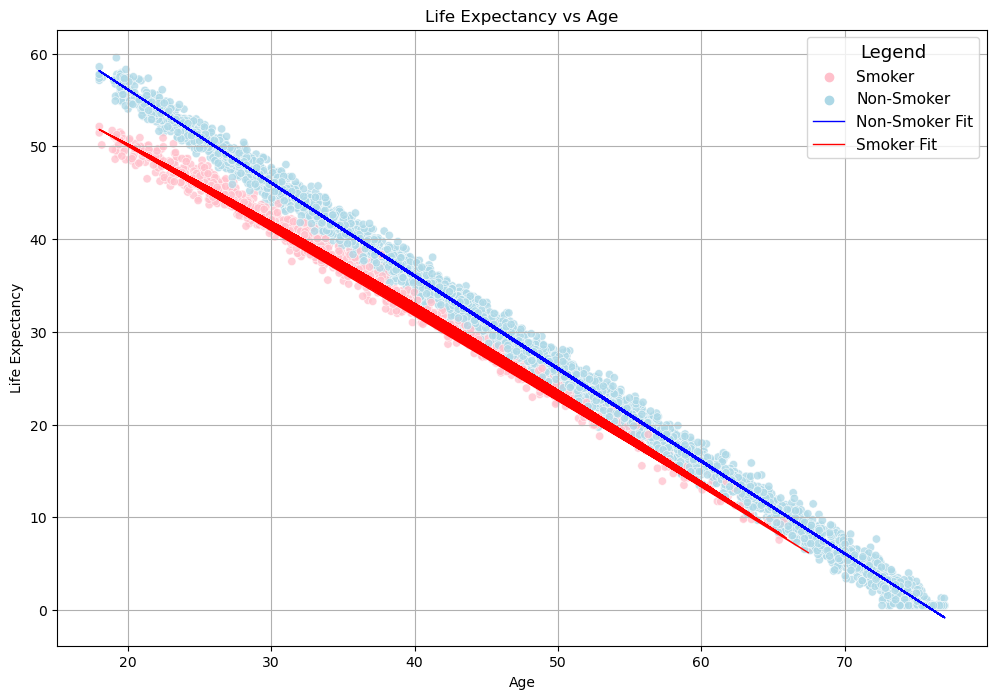

In [48]:
smoking['smoking_status'] = smoking['smoking'].map({0: 'Non-Smoker', 1: 'Smoker'})

f0 = np.polyfit(smoking[smoking['smoking'] == 0]['age'], smoking[smoking['smoking'] == 0]['exyr'], 2)
f1 = np.polyfit(smoking[smoking['smoking'] == 1]['age'], smoking[smoking['smoking'] == 1]['exyr'], 2)

plt.figure(figsize=(12, 8))
sns.scatterplot(x='age', y='exyr', data=smoking, hue='smoking_status', palette=['pink', 'lightblue'], alpha=0.75)  

# Plot regression lines
plt.plot(smoking[smoking['smoking'] == 0]['age'], 
         np.polyval(f0, smoking[smoking['smoking'] == 0]['age']), 
         color='blue',  
         label='Non-Smoker Fit', linewidth=1)  # Label adjusted for clarity

plt.plot(smoking[smoking['smoking'] == 1]['age'], 
         np.polyval(f1, smoking[smoking['smoking'] == 1]['age']), 
         color='red',  
         label='Smoker Fit', linewidth=1)  # Label adjusted for clarity

plt.xlabel('Age')
plt.ylabel('Life Expectancy')
plt.title('Life Expectancy vs Age')

# Let seaborn handle the legend automatically
plt.legend(title='Legend', title_fontsize='13', fontsize='11')
plt.grid(True)
plt.show()

From the graph, we can clearly see a treatment affect as the non-smoker data and fit is clearly pushed "up" when compared against the smoker data. This means that the non-smokes have a larger intercept than the smokers, meaning they live longer lives. Also not that at any given age, the non-smokers have a greater life expectancy than the smokers, which also shows that we expect non-smokers to be healthier than smokers. That said, we do see the lines begin to converge as age increases (they never actually converge, but the difference between the two lines decreases). This is likely due to two reasons: first, our data just has more older non-smokers, so our fit is better and so this is a natural artifact from our limited smoker data. The second reason is that once someone has lived to a certain age, the effect of smoking on life expectancy is lessened. This is likely because for whatever reason the affects of smoking did not severely impact a person's health. Maybe they avoided cancer for genetic reasons or maybe they were able to quit smoking. However, even for non-smokers the risk of cancer, heart disease, and other diseases increases with age. These factors dominate the affects of smoking for the population who has escaped many of the most severe affects of smoking, causing the affect to decrease with age. 

In [49]:
def w(a, h, ages):
    diffs = a - ages[:, None]  # Compute age differences for all combinations
    weights = (1 / (h * np.sqrt(2 * np.pi))) * np.exp(-0.5 * (diffs / h) ** 2)
    return weights

def ATE(h, smoking):
    ages = smoking['age'].values
    exyr = smoking['exyr'].values
    smoking_status = smoking['smoking'].values
    
    age_range = np.linspace(ages.min(), ages.max(), len(ages))
    
    p_a = w(age_range, h, ages)
    density = p_a.mean(axis=0)  

    treatment_effects = np.polyval(f1, age_range) - np.polyval(f0, age_range)
    
    ate = np.sum(density * treatment_effects) / len(age_range)
    return ate

h = 5  
ate_var = ATE(h, smoking)
print("ATE:", ate_var)


ATE: -0.05119591302892386


In [50]:
total_nsmoker_age + ate_var * total_nsmoker_age

72.1152294372076

Note that our ATE is $-0.05$ and is normalized per year. Thus, we can interpret our ATE as the average number of years lost due to smoking per year. Thus, if we take our average age and multiply it by our ATE, we can get the average number of years lost due to smoking. This number agrees with the average age of death for smokers in the dataset.

### Part E

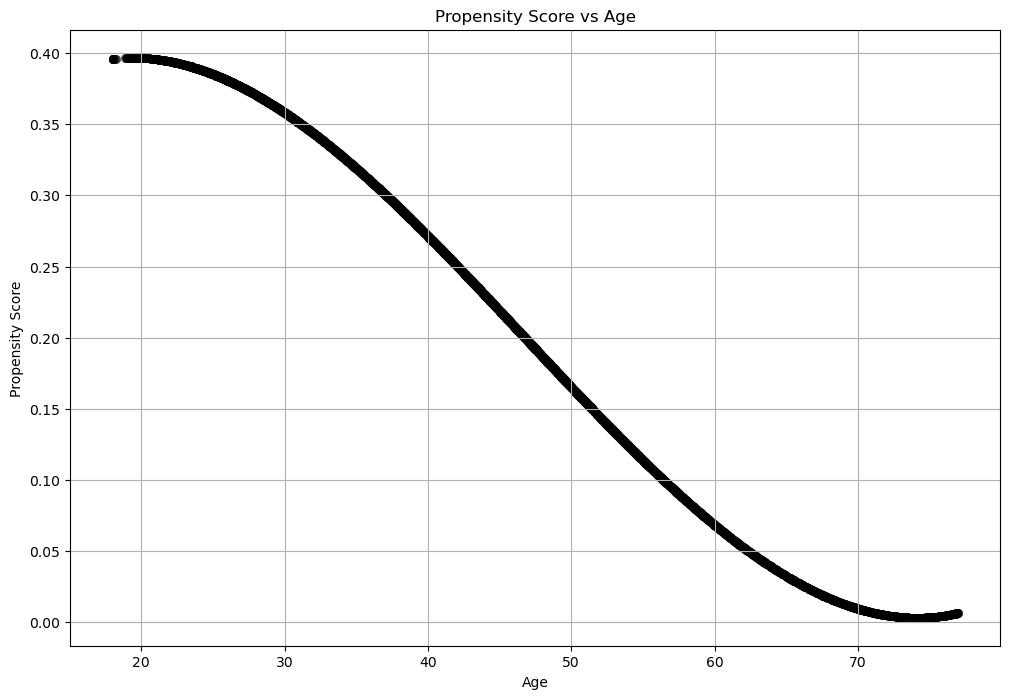

In [51]:
# approximate the propensity score with degree 3 polynomial
def propensity_score(smoking):
    model = np.polyfit(smoking['age'], smoking['smoking'], 3)
    return np.polyval(model, smoking['age'])

# plot the propensity score as a function of age
plt.figure(figsize=(12, 8))
plt.scatter(smoking['age'], propensity_score(smoking), color='black', alpha=0.5, linewidths=0.5, edgecolors='k')
plt.xlabel('Age')
plt.ylabel('Propensity Score')
plt.title('Propensity Score vs Age')
plt.grid(True)
plt.show()

In [52]:
# redo with P instead of X
def ATE(h, smoking):
    ages = smoking['age'].values
    exyr = smoking['exyr'].values
    smoking_status = smoking['smoking'].values
    p = propensity_score(smoking)
    
    age_range = np.linspace(ages.min(), ages.max(), len(ages))
    
    p_a = w(age_range, h, ages)
    density = p_a.mean(axis=0)  

    treatment_effects = (exyr * smoking_status) / p - (exyr * (1 - smoking_status)) / (1 - p)
    
    ate = np.sum(density * treatment_effects) / len(age_range)
    return ate

h = 5
ate_var = ATE(h, smoking)
print("ATE:", ate_var)

ATE: -0.05068376637380959


I don't care here, but with multiple X values, calculating the kernel for the ATE for each X value could be computationally expensive or confusing. For that reason, using propensity scores to calculate the ATE is a good idea. Also our numbers are very similar. 

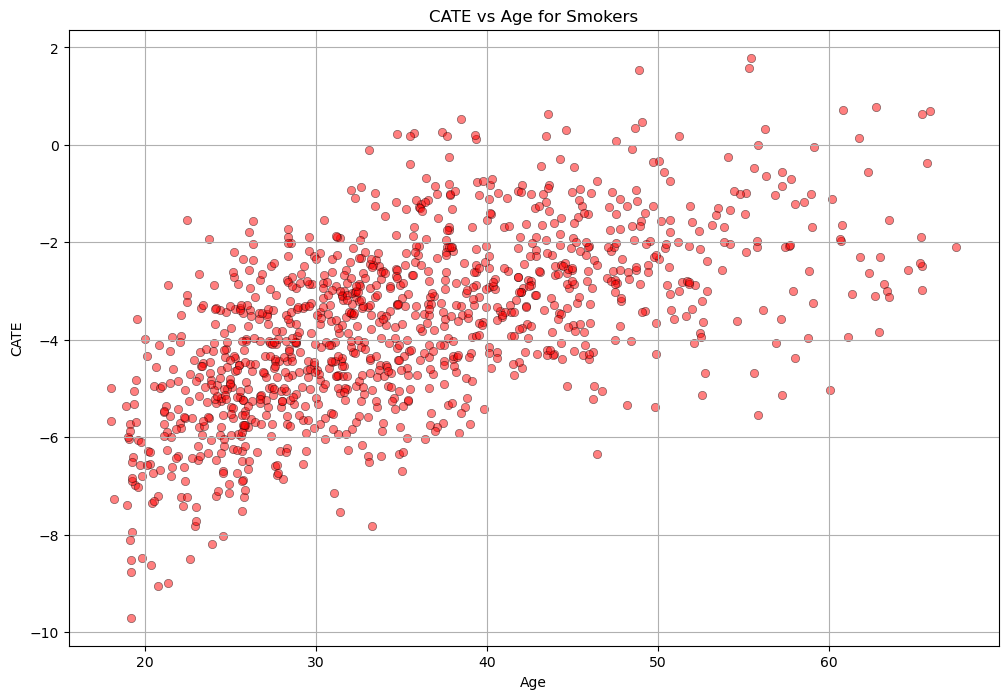

Total Life ATE: -7.974794421163587
ATE per Year:  -0.10492260232136529


In [53]:
def nearest_neighbor_matching(smoking):
    # Split into smoker and non-smoker groups
    smokers = smoking[smoking['smoking'] == 1].copy()
    non_smokers = smoking[smoking['smoking'] == 0].copy()
    
    # Find nearest non-smoker neighbor for each smoker based on age
    smokers['nn'] = smokers['age'].apply(lambda x: (non_smokers['age'] - x).abs().idxmin())
    
    # Find nearest smoker neighbor for each non-smoker based on age
    non_smokers['nn'] = non_smokers['age'].apply(lambda x: (smokers['age'] - x).abs().idxmin())
    
    return smokers, non_smokers

# Matching smokers and non-smokers
smokers, non_smokers = nearest_neighbor_matching(smoking)

# Calculating CATE for each smoker by comparing with their matched non-smoker
smokers['CATE'] = smokers.apply(lambda row: row['exyr'] - non_smokers.loc[non_smokers.index == row['nn'], 'exyr'].values[0], axis=1)

# Plotting CATE vs Age for smokers
plt.figure(figsize=(12, 8))
plt.scatter(smokers['age'], smokers['CATE'], color='red', alpha=0.5, linewidths=0.5, edgecolors='k')
plt.xlabel('Age')
plt.ylabel('CATE')
plt.title('CATE vs Age for Smokers')
plt.grid(True)
plt.show()

# Calculating ATE as the mean difference in life expectancy between all smokers and non-smokers
ATE = non_smokers['exyr'].mean() - smokers['exyr'].mean() 

print("Total Life ATE:", ATE)
print("ATE per Year: ", ATE / total_nsmoker_age)

Note that our value here is of slightly larger magnitude than the previous value. We already know that our non-smokers tend to be old than our smokers in this dataset (for whatever reason), and so when we do our matching, we are not matching perfectly. That is, we don't always have someone who is a good comparison for any given individual. This is likely causing the discrepancy between the two values. If this is how statistics was supposed to work, then there would be no need for means or regressions or anything. Thus, I am not a fan of this approach. It is a decent approximation, but it is not perfect.

## Part 3
Find an economics paper that uses selection on observables for which data is available and that you find remotely interesting. Answer the following questions, a few sentences should suffice for each question.

### Part A:
**List title, author(s), journal, publication date**

Title: Estimating the Payoff to Attending a More Selective College: An Application of Selection on Observables and Unobservables
Authors: Stacy Berg Dale & Alan B. Krueger
Journal: National Bureau of Economic Research
Publication Date: August 1999

### Part B
**What is the causal question they ask, i.e. what is the treatment and what is the outcome?**

The causal question investigated in the paper is the effect of attending a more selective college (treatment) on students’ subsequent earnings (outcome).	
	
### Part C
**Why does the author/why do the authors expect selection into treatment?**

The authors expect selection into treatment due to the admissions process of more selective colleges, which likely consider both observable and unobservable characteristics related to students' future earnings potential. This means students who attend these colleges may already have higher earnings potential before college through characteristics such as motivation, prior academic achievement, and socioeconomic status, leading to a selection bias in estimating the causal effect of college selectivity on earnings.

### Part D 
**What observables are used to control for treatment?**

To control for this treatment effect, the study uses observable variables that include students' SAT scores, the average SAT scores of colleges they applied to, and the set of colleges where they were accepted or rejected. These variables help create a more accurate comparison between students who attended more selective colleges and those who did not. The researchers aimed to isolate the effect of college selectivity on future earnings from other factors that could influence earnings.


# Problem 4

## Part 1

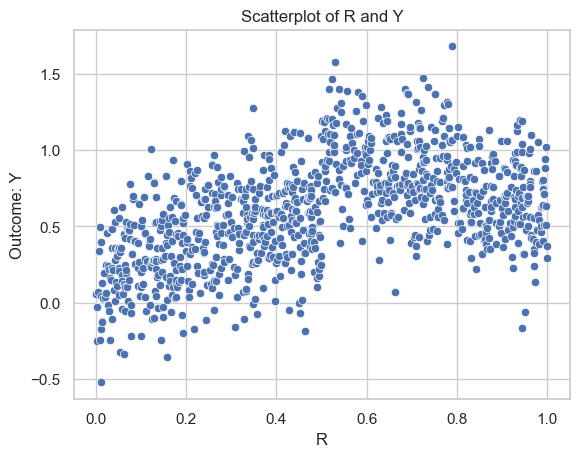

In [54]:
# we will load and plot the data - MV
rd_data = pd.read_csv('rd.csv')
rd_data = rd_data.drop(columns=['Unnamed: 0'])

# use seaborn to plot the data - MV
sns.set(style="whitegrid")
ax = sns.scatterplot(x = rd_data['R'], y = rd_data['Y'])
ax.set(xlabel='R', ylabel='Outcome: Y')
plt.title('Scatterplot of R and Y')
plt.show()

Yes, you can see a discontinuity at 0.5. 

## Part 2
I kind of like the idea of running the regression over the entire dataset to either side of the discontinuity. This way, we can see if the regression is different on either side of the discontinuity.

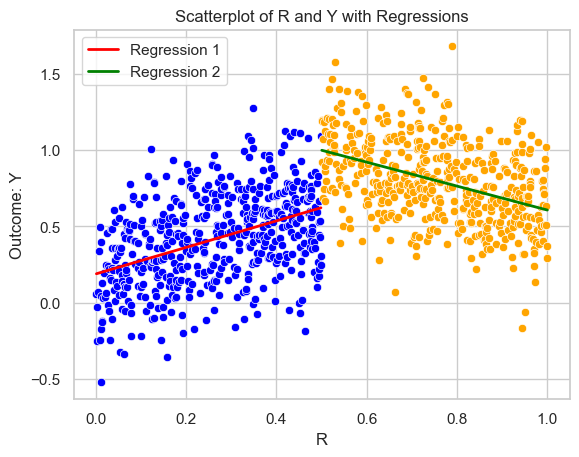

In [55]:
# run the regressions on either side of 0.5 - MV

# create the dataframes - MV
rd_data_1 = rd_data[rd_data['R'] <= 0.5]
rd_data_2 = rd_data[rd_data['R'] > 0.5]

# run the regressions - MV
regression_1 = np.polyfit(rd_data_1['R'], rd_data_1['Y'], 1)
regression_2 = np.polyfit(rd_data_2['R'], rd_data_2['Y'], 1)

# plot the data and the regressions - MV
sns.set(style="whitegrid")
ax = sns.scatterplot(x = rd_data_1['R'], y = rd_data_1['Y'], color = 'blue')
ax = sns.scatterplot(x = rd_data_2['R'], y = rd_data_2['Y'], color = 'orange')
ax.set(xlabel='R', ylabel='Outcome: Y')
plt.plot(rd_data_1['R'], np.polyval(regression_1, rd_data_1['R']), color = 'red', label = 'Regression 1', linewidth = 2)
plt.plot(rd_data_2['R'], np.polyval(regression_2, rd_data_2['R']), color = 'green', label = 'Regression 2', linewidth = 2)
plt.title('Scatterplot of R and Y with Regressions')
plt.legend()
plt.show()

As much as I liked this idea it seemed that Jonas did not like this idea given his response to someone on Ed. Let's try with a buffer of 0.25. 

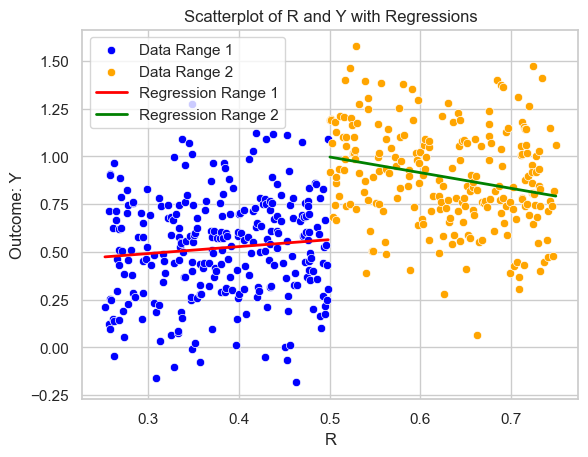

In [56]:
rd_data_25_1 = rd_data[(rd_data['R'] <= 0.5) & (rd_data['R'] > 0.25)]
rd_data_25_2 = rd_data[(rd_data['R'] > 0.5) & (rd_data['R'] <= 0.75)]

regression_range_1 = np.polyfit(rd_data_25_1['R'], rd_data_25_1['Y'], 1)
regression_range_2 = np.polyfit(rd_data_25_2['R'], rd_data_25_2['Y'], 1)

sns.set(style="whitegrid")
ax = sns.scatterplot(x='R', y='Y', data=rd_data_25_1, color='blue', label='Data Range 1')
ax = sns.scatterplot(x='R', y='Y', data=rd_data_25_2, color='orange', label='Data Range 2')
ax.set(xlabel='R', ylabel='Outcome: Y')

plt.plot(rd_data_25_1['R'], np.polyval(regression_range_1, rd_data_25_1['R']), color='red', label='Regression Range 1', linewidth=2)
plt.plot(rd_data_25_2['R'], np.polyval(regression_range_2, rd_data_25_2['R']), color='green', label='Regression Range 2', linewidth=2)

plt.title('Scatterplot of R and Y with Regressions')
plt.legend()
plt.show()

## Part 3
To estimate the treatment effect, we will find the jump at 0.5. 

In [57]:
# Estimating the jump
jump = (regression_2[1] + regression_2[0] * 0.5) - (regression_1[1] + regression_1[0] * 0.5) # Polyfit returns the slope first - MV
print(f'The estimated treatment affect at the cutoff is {jump}')

The estimated treatment affect at the cutoff is 0.3761150400692135


In [58]:
# Estimating the jump
jump = (regression_range_2[1] + regression_range_2[0] * 0.5) - (regression_range_1[1] + regression_range_1[0] * 0.5) # Polyfit returns the slope first - MV
print(f'The estimated treatment affect at the cutoff is {jump}')

The estimated treatment affect at the cutoff is 0.43327242596084103


Okay so, it seems that our affect at 0.5 is somewhere around 0.4. Depending on how large of a buffer we use, we get different results. Note that there is a tradeoff here of more accurate local linear fits and more bias in our estimates. The less data we use, the more bias we have in our estimates, but the more accurate our local linear fits are. Since these predictions are so close, I would be inclined to use the larger buffer because it has more data and is likely to be less biased, but also it likely does not matter since they are close. 

## Part 4

Problem 4.4: Find an economics paper that uses regression discontinuity, for which data is available and that you find remotely interesting. Answer the following questions, a few sentences should suffice for each question.

### Part A

**List title, author(s), journal, publication date**

Title: Measuring the effects of European Regional Policy on economic growth: A regression discontinuity approach
Authors: Guido Pellegrini, Flavia Terribile, Ornella Tarola, Teo Muccigrosso, Federic Busillo
Journal: Papers in Regional Science
Publication Date: March 2013

### Part B

**What is the causal question they ask, i.e. what is the treatment and what is the outcome?**

The causal question is the effect of European Regional Policy on the economic growth of regions  (outcome) that are just below and just above the eligibility threshold for receiving funds (the treatment).

### Part C
**Why does the author/why do the authors expect selection into treatment?**

The authors expect selection into treatment because the allocation of EU Regional Policy funds is based on a cutoff point. That cutoff point states that regions with a per capita GDP below 75% of the EU average are eligible for funds, which introduces a natural selection mechanism for treatment based on economic criteria determined by available data and policy at the time.

### Part D

**Why does the author/why do the authors expect a discontinuity in treatment assignment?**

The authors expect a discontinuity in treatment assignment because the European Regional Policy uses a clear, predefined GDP per capita threshold to determine funding eligibility. Regions just below this cutoff are eligible for assistance, while those just above are not. This creates a natural experiment setting, allowing for the comparison of similar regions on either side of the threshold to estimate the policy's impact on economic growth through a regression discontinuity design analysis, assuming regions near the cutoff are comparable except for their eligibility for funding.